### 数据展示

In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import UnivariateSpline
from sklearn import linear_model
import xgboost as xgb
from sklearn.utils import *

道路通行时间：

In [2]:
df = pd.read_csv('new_gy_contest_traveltime_training_data_second.txt',delimiter=';',dtype={'link_ID':object})
df.head()

,link_ID,date,time_interval,travel_time
0,4377906283422600514,2017-05-06,"[2017-05-06 11:04:00,2017-05-06 11:06:00)",3.0
1,3377906289434510514,2017-05-06,"[2017-05-06 10:42:00,2017-05-06 10:44:00)",1.0
2,3377906285934510514,2017-05-06,"[2017-05-06 11:56:00,2017-05-06 11:58:00)",35.2
3,3377906285934510514,2017-05-06,"[2017-05-06 17:46:00,2017-05-06 17:48:00)",26.2
4,3377906287934510514,2017-05-06,"[2017-05-06 10:52:00,2017-05-06 10:54:00)",10.4


time_interval时间间隔，两分钟为单位

travel_time平均通行时间

道理长宽情况：

In [3]:
link_df = pd.read_csv('gy_contest_link_info.txt',delimiter=';',dtype={'link_ID':object})
link_df.head()

,link_ID,length,width,link_class
0,4377906289869500514,57,3,1
1,4377906284594800514,247,9,1
2,4377906289425800514,194,3,1
3,4377906284525800514,839,3,1
4,4377906284422600514,55,12,1


length长度    width宽度    link_class类别

道路之间连接情况：

In [4]:
link_tops = pd.read_csv('gy_contest_link_top_update.txt',delimiter=',',dtype={'link_ID':object})
link_tops.head()

,link_ID,in_links,out_links
0,4377906289869500514,1,1
1,4377906284594800514,1,1
2,4377906289425800514,1,1
3,4377906284525800514,1,1
4,4377906284422600514,2,1


### 任务：预测未来一个月平均通行结果，每两分钟一次
回归任务

构建时间序列，基于前几天或者前几十天的数据预测
https://tianchi.aliyun.com/competition/entrance/231598/information

### 数据集筛选与标签转换
数据集中有些数据可能由于异常情况导致不适合建模（堵车，维修等）

In [5]:
df.head()

,link_ID,date,time_interval,travel_time
0,4377906283422600514,2017-05-06,"[2017-05-06 11:04:00,2017-05-06 11:06:00)",3.0
1,3377906289434510514,2017-05-06,"[2017-05-06 10:42:00,2017-05-06 10:44:00)",1.0
2,3377906285934510514,2017-05-06,"[2017-05-06 11:56:00,2017-05-06 11:58:00)",35.2
3,3377906285934510514,2017-05-06,"[2017-05-06 17:46:00,2017-05-06 17:48:00)",26.2
4,3377906287934510514,2017-05-06,"[2017-05-06 10:52:00,2017-05-06 10:54:00)",10.4


In [6]:
#截取开始时间
df['time_interval_begin'] = pd.to_datetime(df['time_interval'].map(lambda x: x[1:20]))
df.head()

,link_ID,date,time_interval,travel_time,time_interval_begin
0,4377906283422600514,2017-05-06,"[2017-05-06 11:04:00,2017-05-06 11:06:00)",3.0,2017-05-06 11:04:00
1,3377906289434510514,2017-05-06,"[2017-05-06 10:42:00,2017-05-06 10:44:00)",1.0,2017-05-06 10:42:00
2,3377906285934510514,2017-05-06,"[2017-05-06 11:56:00,2017-05-06 11:58:00)",35.2,2017-05-06 11:56:00
3,3377906285934510514,2017-05-06,"[2017-05-06 17:46:00,2017-05-06 17:48:00)",26.2,2017-05-06 17:46:00
4,3377906287934510514,2017-05-06,"[2017-05-06 10:52:00,2017-05-06 10:54:00)",10.4,2017-05-06 10:52:00


标签转换
<img src="assets/20201202211044.png" width="100%">
对于travel_time，我们希望是右边的图，越是正态分布，越好预测

In [7]:
df = df.drop(['time_interval'],axis=1)
df['travel_time'] = np.log1p(df['travel_time'])

筛选方法

In [8]:
#剔除一些离群点：如travel_time突然有几百分钟的时间，可能是意外、道路维修或者统计错误
def quantile_clip(group):
    # 选择一定的百分比过滤
    group[group < group.quantile(.05)] = group.quantile(.05)
    group[group > group.quantile(.95)] = group.quantile(.95)
    return group

In [9]:
#对每条道路(link_ID)，每天执行(date)
df['travel_time'] = df.groupby(['link_ID','date'])['travel_time'].transform(quantile_clip)
df.head(5)

,link_ID,date,travel_time,time_interval_begin
0,4377906283422600514,2017-05-06,1.386294,2017-05-06 11:04:00
1,3377906289434510514,2017-05-06,0.693147,2017-05-06 10:42:00
2,3377906285934510514,2017-05-06,3.589059,2017-05-06 11:56:00
3,3377906285934510514,2017-05-06,3.303217,2017-05-06 17:46:00
4,3377906287934510514,2017-05-06,2.251292,2017-05-06 10:52:00


In [10]:
#根据需求选择样本数据，比如预测高峰时刻，如早上6-8、中午下午13-18
df = df.loc[(df['time_interval_begin'].dt.hour.isin([6,7,8,13,14,15,16,17,18]))]

In [11]:
#保存处理结果
df.to_csv('raw_data.txt',header=True,index=None,sep=';',mode='w')

### 缺失值预处理

In [12]:
df = pd.read_csv('raw_data.txt',delimiter=';',parse_dates=['time_interval_begin'],dtype={'link_ID':object})
df.head()

,link_ID,date,travel_time,time_interval_begin
0,3377906285934510514,2017-05-06,3.303217,2017-05-06 17:46:00
1,3377906287934510514,2017-05-06,1.887070,2017-05-06 14:36:00
2,3377906287674510514,2017-05-06,1.931521,2017-05-06 06:30:00
3,3377906287886510514,2017-05-06,3.616309,2017-05-06 07:32:00
4,4377906283759500514,2017-05-06,2.140066,2017-05-06 13:24:00


如上第一行中，2017-05-06 17:46:00，那么是不是没有17:48、17:50，所以我们需要补充

In [13]:
link_df.head()

,link_ID,length,width,link_class
0,4377906289869500514,57,3,1
1,4377906284594800514,247,9,1
2,4377906289425800514,194,3,1
3,4377906284525800514,839,3,1
4,4377906284422600514,55,12,1


In [14]:
date_range = pd.date_range('2017-03-01 00:00:00','2017-07-31 23:58:00',freq='2min')
date_range[:5]

DatetimeIndex(['2017-03-01 00:00:00', '2017-03-01 00:02:00',
               '2017-03-01 00:04:00', '2017-03-01 00:06:00',
               '2017-03-01 00:08:00'],
              dtype='datetime64[ns]', freq='2T')

In [15]:
#给每个ID，做出每一个时刻
new_index = pd.MultiIndex.from_product([link_df['link_ID'].unique(),date_range],
                                      names=['link_ID', 'time_interval_begin'])
new_df = pd.DataFrame(index=new_index).reset_index()
new_df.head()  # 此时每个ID都有从2017-03-01 00:00:00到2017-03-71 23:58:00的时间间隔

,link_ID,time_interval_begin
0,4377906289869500514,2017-03-01 00:00:00
1,4377906289869500514,2017-03-01 00:02:00
2,4377906289869500514,2017-03-01 00:04:00
3,4377906289869500514,2017-03-01 00:06:00
4,4377906289869500514,2017-03-01 00:08:00


In [16]:
#原来的表里也有部分值，进行合并，出现大量缺失值
df2 = pd.merge(new_df, df,on=['link_ID','time_interval_begin'],how='left')
df2.head()

,link_ID,time_interval_begin,date,travel_time
0,4377906289869500514,2017-03-01 00:00:00,NaN,NaN
1,4377906289869500514,2017-03-01 00:02:00,NaN,NaN
2,4377906289869500514,2017-03-01 00:04:00,NaN,NaN
3,4377906289869500514,2017-03-01 00:06:00,NaN,NaN
4,4377906289869500514,2017-03-01 00:08:00,NaN,NaN


In [17]:
#筛选时间段数据
df2 = df2.loc[(df2['time_interval_begin'].dt.hour.isin([6,7,8,13,14,15,16,17,18]))]
df2 = df2.loc[~((df2['time_interval_begin'].dt.year == 2017) & 
                (df2['time_interval_begin'].dt.month == 7) & 
                (df2['time_interval_begin'].dt.hour.isin([8,15,18])))]
df2 = df2.loc[~((df2['time_interval_begin'].dt.year == 2017) & 
                (df2['time_interval_begin'].dt.month == 3) & 
                (df2['time_interval_begin'].dt.day == 31))]

df2['date'] = df2['time_interval_begin'].dt.strftime('%Y-%m-%d')

In [18]:
df2.head()

,link_ID,time_interval_begin,date,travel_time
180,4377906289869500514,2017-03-01 06:00:00,2017-03-01,2.174752
181,4377906289869500514,2017-03-01 06:02:00,2017-03-01,2.174752
182,4377906289869500514,2017-03-01 06:04:00,2017-03-01,2.174752
183,4377906289869500514,2017-03-01 06:06:00,2017-03-01,2.174752
184,4377906289869500514,2017-03-01 06:08:00,2017-03-01,2.174752


In [19]:
#保存中间结果
df2.to_csv('pre_trainning.txt',header=True,index=None,sep=';',mode='w')

### 补全时间序列

In [20]:
df = df2
df['travel_time2'] = df['travel_time']
df.head()

,link_ID,time_interval_begin,date,travel_time,travel_time2
180,4377906289869500514,2017-03-01 06:00:00,2017-03-01,2.174752,2.174752
181,4377906289869500514,2017-03-01 06:02:00,2017-03-01,2.174752,2.174752
182,4377906289869500514,2017-03-01 06:04:00,2017-03-01,2.174752,2.174752
183,4377906289869500514,2017-03-01 06:06:00,2017-03-01,2.174752,2.174752
184,4377906289869500514,2017-03-01 06:08:00,2017-03-01,2.174752,2.174752


多个月统计-季节性变化

In [21]:
def date_trend(group):
    tmp = group.groupby('date_hour').mean().reset_index()
    
    def nan_helper(y):
        return np.isnan(y), lambda z: z.nonzero()[0]
    
    y = tmp['travel_time'].values
    nans, x = nan_helper(y)
    if group.link_ID.values[0] in ['3377906282328510514','3377906283328510514',
                                  '4377906280784800514','9377906281555510514']:
        tmp['date_trend'] = group['travel_time'].median()
    else:
        regr = linear_model.LinearRegression()
        regr.fit(x(~nans).reshape(-1,1), y[~nans].reshape(-1,1))
        tmp['date_trend'] = regr.predict(tmp.index.values.reshape(-1,1)).ravel()
    group = pd.merge(group,tmp[['date_trend','date_hour']], on='date_hour',how='left')
    return group

In [22]:
# 基于小时进行预测，如果基于整体预测，结果可能不准确定，我们先算小时对结果的影响
df['date_hour'] = df.time_interval_begin.map(lambda x: x.strftime('%Y-%m-%d-%H'))
df.head()

,link_ID,time_interval_begin,date,travel_time,travel_time2,date_hour
180,4377906289869500514,2017-03-01 06:00:00,2017-03-01,2.174752,2.174752,2017-03-01-06
181,4377906289869500514,2017-03-01 06:02:00,2017-03-01,2.174752,2.174752,2017-03-01-06
182,4377906289869500514,2017-03-01 06:04:00,2017-03-01,2.174752,2.174752,2017-03-01-06
183,4377906289869500514,2017-03-01 06:06:00,2017-03-01,2.174752,2.174752,2017-03-01-06
184,4377906289869500514,2017-03-01 06:08:00,2017-03-01,2.174752,2.174752,2017-03-01-06


道路每小时通行时间的回归结果
<img src="assets/20201202221436.png" width="100%">
左图：回归预测，蓝色线是回归线，红色是时间
右图：对某几个道路，直接用中位数预测

In [23]:
df = df.groupby('link_ID').apply(date_trend)
df.head()

link_ID time_interval_begin        date  \
link_ID                                                                      
3377906280028510514 0  3377906280028510514 2017-03-01 06:00:00  2017-03-01   
                    1  3377906280028510514 2017-03-01 06:02:00  2017-03-01   
                    2  3377906280028510514 2017-03-01 06:04:00  2017-03-01   
                    3  3377906280028510514 2017-03-01 06:06:00  2017-03-01   
                    4  3377906280028510514 2017-03-01 06:08:00  2017-03-01   

                       travel_time  travel_time2      date_hour  date_trend  
link_ID                                                                      
3377906280028510514 0          NaN           NaN  2017-03-01-06    1.960745  
                    1          NaN           NaN  2017-03-01-06    1.960745  
                    2          NaN           NaN  2017-03-01-06    1.960745  
                    3          NaN           NaN  2017-03-01-06    1.960745  
                    4          NaN           NaN  2017-03-01-06    1.960745

蓝线回归得到的值存在 df['date trend']里,此时 travel_time 就更新为 df['travel_time']= df['travel_time']-df['date_trend'],表示date_trend作为大的趋势已经被线性回归决定了,剩下的就是研究这个残差了,之后训练和预测都是基于残差,最后用预测出来的残差加上相应的date_trend即可得到需要的预测值

In [24]:
df = df.drop(['date_hour','link_ID'],axis=1)
df = df.reset_index()
df = df.drop('level_1',axis=1)
df['travel_time'] = df['travel_time'] - df['date_trend']
df.head()

,link_ID,time_interval_begin,date,travel_time,travel_time2,date_trend
0,3377906280028510514,2017-03-01 06:00:00,2017-03-01,NaN,NaN,1.960745
1,3377906280028510514,2017-03-01 06:02:00,2017-03-01,NaN,NaN,1.960745
2,3377906280028510514,2017-03-01 06:04:00,2017-03-01,NaN,NaN,1.960745
3,3377906280028510514,2017-03-01 06:06:00,2017-03-01,NaN,NaN,1.960745
4,3377906280028510514,2017-03-01 06:08:00,2017-03-01,NaN,NaN,1.960745


日变化量（分钟）

In [25]:
def minute_trend(group):
    tmp = group.groupby('hour_minute').mean().reset_index()
    #s的值越小，对数据的拟合越好，但是存在过拟合风险
    spl = UnivariateSpline(tmp.index, tmp['travel_time'].values, s=0.5)
    tmp['minute_trend'] = spl(tmp.index)
    group = pd.merge(group, tmp[['minute_trend', 'hour_minute']], on='hour_minute', how='left')
    return group

In [26]:
df['hour_minute'] = df.time_interval_begin.map(lambda x: x.strftime('%H-%M'))
df.head()

,link_ID,time_interval_begin,date,travel_time,travel_time2,date_trend,hour_minute
0,3377906280028510514,2017-03-01 06:00:00,2017-03-01,NaN,NaN,1.960745,06-00
1,3377906280028510514,2017-03-01 06:02:00,2017-03-01,NaN,NaN,1.960745,06-02
2,3377906280028510514,2017-03-01 06:04:00,2017-03-01,NaN,NaN,1.960745,06-04
3,3377906280028510514,2017-03-01 06:06:00,2017-03-01,NaN,NaN,1.960745,06-06
4,3377906280028510514,2017-03-01 06:08:00,2017-03-01,NaN,NaN,1.960745,06-08


In [27]:
df=df.groupby('link_ID').apply(minute_trend)
df.head()

link_ID time_interval_begin        date  \
link_ID                                                                      
3377906280028510514 0  3377906280028510514 2017-03-01 06:00:00  2017-03-01   
                    1  3377906280028510514 2017-03-01 06:02:00  2017-03-01   
                    2  3377906280028510514 2017-03-01 06:04:00  2017-03-01   
                    3  3377906280028510514 2017-03-01 06:06:00  2017-03-01   
                    4  3377906280028510514 2017-03-01 06:08:00  2017-03-01   

                       travel_time  travel_time2  date_trend hour_minute  \
link_ID                                                                    
3377906280028510514 0          NaN           NaN    1.960745       06-00   
                    1          NaN           NaN    1.960745       06-02   
                    2          NaN           NaN    1.960745       06-04   
                    3          NaN           NaN    1.960745       06-06   
                    4          NaN           NaN    1.960745       06-08   

                       minute_trend  
link_ID                              
3377906280028510514 0     -0.252121  
                    1     -0.246743  
                    2     -0.241428  
                    3     -0.236176  
                    4     -0.230986

与季节残差一样,回归得到的值存在 df['minute_trend']里,因此现在的travel_time再次更新为 df['travel_time]= df['travel_time']-df['minute_trend]

In [28]:
df = df.drop(['hour_minute', 'link_ID'], axis=1)
df = df.reset_index()
df = df.drop('level_1',axis=1)
df['travel_time'] = df['travel_time'] - df['minute_trend']

In [29]:
df.head()

,link_ID,time_interval_begin,date,travel_time,travel_time2,date_trend,minute_trend
0,3377906280028510514,2017-03-01 06:00:00,2017-03-01,NaN,NaN,1.960745,-0.252121
1,3377906280028510514,2017-03-01 06:02:00,2017-03-01,NaN,NaN,1.960745,-0.246743
2,3377906280028510514,2017-03-01 06:04:00,2017-03-01,NaN,NaN,1.960745,-0.241428
3,3377906280028510514,2017-03-01 06:06:00,2017-03-01,NaN,NaN,1.960745,-0.236176
4,3377906280028510514,2017-03-01 06:08:00,2017-03-01,NaN,NaN,1.960745,-0.230986


In [30]:
link_infos = pd.read_csv('gy_contest_link_info.txt',delimiter=';',dtype={'link_ID':object})
link_tops = pd.read_csv('gy_contest_link_top_update.txt',delimiter=',',dtype={'link_ID':object})

基本上大概的走势已经被 date_trend和 hour_trend决定了,剩下就是建模得到这个travel_time如何围绕这两个trends上下变化的

选择训练特征：

In [31]:
link_infos = pd.merge(link_infos, link_tops, on=['link_ID'], how='left')
link_infos['links_num'] = link_infos['in_links']+link_infos['out_links']
link_infos['area'] = link_infos['length'] * link_infos['width']
df = pd.merge(df, link_infos[['link_ID','length','width', 'links_num', 'area']], on=['link_ID'], how='left')
df.head()

,link_ID,time_interval_begin,date,travel_time,travel_time2,date_trend,minute_trend,length,width,links_num,area
0,3377906280028510514,2017-03-01 06:00:00,2017-03-01,NaN,NaN,1.960745,-0.252121,48,3,2,144
1,3377906280028510514,2017-03-01 06:02:00,2017-03-01,NaN,NaN,1.960745,-0.246743,48,3,2,144
2,3377906280028510514,2017-03-01 06:04:00,2017-03-01,NaN,NaN,1.960745,-0.241428,48,3,2,144
3,3377906280028510514,2017-03-01 06:06:00,2017-03-01,NaN,NaN,1.960745,-0.236176,48,3,2,144
4,3377906280028510514,2017-03-01 06:08:00,2017-03-01,NaN,NaN,1.960745,-0.230986,48,3,2,144


In [32]:
#时间相关特征
df.loc[df['date'].isin(['2017-04-02','2017-04-03','2017-04-04','2017-04-29','2017-04-30',
                       '2017-05-01','2017-05-28','2017-05-29','2017-05-30']),'vacation']=1

df.loc[~df['date'].isin(['2017-04-02','2017-04-03','2017-04-04','2017-04-29','2017-04-30',
                       '2017-05-01','2017-05-28','2017-05-29','2017-05-30']),'vacation']=0

df['minute'] = df['time_interval_begin'].dt.minute
df['hour'] = df['time_interval_begin'].dt.hour
df['day'] = df['time_interval_begin'].dt.day
df['week_day'] = df['time_interval_begin'].map(lambda x: x.weekday() + 1)
df['month'] = df['time_interval_begin'].dt.month
df.head()

,link_ID,time_interval_begin,date,travel_time,travel_time2,date_trend,minute_trend,length,width,links_num,area,vacation,minute,hour,day,week_day,month
0,3377906280028510514,2017-03-01 06:00:00,2017-03-01,NaN,NaN,1.960745,-0.252121,48,3,2,144,0.0,0,6,1,3,3
1,3377906280028510514,2017-03-01 06:02:00,2017-03-01,NaN,NaN,1.960745,-0.246743,48,3,2,144,0.0,2,6,1,3,3
2,3377906280028510514,2017-03-01 06:04:00,2017-03-01,NaN,NaN,1.960745,-0.241428,48,3,2,144,0.0,4,6,1,3,3
3,3377906280028510514,2017-03-01 06:06:00,2017-03-01,NaN,NaN,1.960745,-0.236176,48,3,2,144,0.0,6,6,1,3,3
4,3377906280028510514,2017-03-01 06:08:00,2017-03-01,NaN,NaN,1.960745,-0.230986,48,3,2,144,0.0,8,6,1,3,3


In [33]:
def mean_time(group):
    group['link_ID_en'] = group['travel_time'].mean()
    return group

In [34]:
df = df.groupby('link_ID').apply(mean_time)
df.head()

,link_ID,time_interval_begin,date,travel_time,travel_time2,date_trend,minute_trend,length,width,links_num,area,vacation,minute,hour,day,week_day,month,link_ID_en
0,3377906280028510514,2017-03-01 06:00:00,2017-03-01,NaN,NaN,1.960745,-0.252121,48,3,2,144,0.0,0,6,1,3,3,0.000138
1,3377906280028510514,2017-03-01 06:02:00,2017-03-01,NaN,NaN,1.960745,-0.246743,48,3,2,144,0.0,2,6,1,3,3,0.000138
2,3377906280028510514,2017-03-01 06:04:00,2017-03-01,NaN,NaN,1.960745,-0.241428,48,3,2,144,0.0,4,6,1,3,3,0.000138
3,3377906280028510514,2017-03-01 06:06:00,2017-03-01,NaN,NaN,1.960745,-0.236176,48,3,2,144,0.0,6,6,1,3,3,0.000138
4,3377906280028510514,2017-03-01 06:08:00,2017-03-01,NaN,NaN,1.960745,-0.230986,48,3,2,144,0.0,8,6,1,3,3,0.000138


In [35]:
# 通行时间长的编号大
sorted_link = np.sort(df['link_ID_en'].unique())
df['link_ID_en'] = df['link_ID_en'].map(lambda x: np.argmin(x >= sorted_link))
df.head()

,link_ID,time_interval_begin,date,travel_time,travel_time2,date_trend,minute_trend,length,width,links_num,area,vacation,minute,hour,day,week_day,month,link_ID_en
0,3377906280028510514,2017-03-01 06:00:00,2017-03-01,NaN,NaN,1.960745,-0.252121,48,3,2,144,0.0,0,6,1,3,3,75
1,3377906280028510514,2017-03-01 06:02:00,2017-03-01,NaN,NaN,1.960745,-0.246743,48,3,2,144,0.0,2,6,1,3,3,75
2,3377906280028510514,2017-03-01 06:04:00,2017-03-01,NaN,NaN,1.960745,-0.241428,48,3,2,144,0.0,4,6,1,3,3,75
3,3377906280028510514,2017-03-01 06:06:00,2017-03-01,NaN,NaN,1.960745,-0.236176,48,3,2,144,0.0,6,6,1,3,3,75
4,3377906280028510514,2017-03-01 06:08:00,2017-03-01,NaN,NaN,1.960745,-0.230986,48,3,2,144,0.0,8,6,1,3,3,75


标准化

In [36]:
def std(group):
    group['travel_time_std'] = np.std(group['travel_time'])
    return group

In [37]:
df = df.groupby('link_ID').apply(std)
df['travel_time'] = df['travel_time'] / df['travel_time_std']
df.head()

,link_ID,time_interval_begin,date,travel_time,travel_time2,date_trend,minute_trend,length,width,links_num,area,vacation,minute,hour,day,week_day,month,link_ID_en,travel_time_std
0,3377906280028510514,2017-03-01 06:00:00,2017-03-01,NaN,NaN,1.960745,-0.252121,48,3,2,144,0.0,0,6,1,3,3,75,0.223232
1,3377906280028510514,2017-03-01 06:02:00,2017-03-01,NaN,NaN,1.960745,-0.246743,48,3,2,144,0.0,2,6,1,3,3,75,0.223232
2,3377906280028510514,2017-03-01 06:04:00,2017-03-01,NaN,NaN,1.960745,-0.241428,48,3,2,144,0.0,4,6,1,3,3,75,0.223232
3,3377906280028510514,2017-03-01 06:06:00,2017-03-01,NaN,NaN,1.960745,-0.236176,48,3,2,144,0.0,6,6,1,3,3,75,0.223232
4,3377906280028510514,2017-03-01 06:08:00,2017-03-01,NaN,NaN,1.960745,-0.230986,48,3,2,144,0.0,8,6,1,3,3,75,0.223232


缺失时间预测

In [38]:
params = {
    'learning_rate':0.2,
    'n_estimators':30,
    'subsample':0.8,
    'colsample_bytree':0.6,
    'max_depth':10,
    'min_child_weight':1,
    'reg_alpha':0,
    'gamma':0
}

In [39]:
df = pd.get_dummies(df, columns=['links_num','width','minute','hour',
                                 'week_day','day','month'])
df.head()

,link_ID,time_interval_begin,date,travel_time,travel_time2,date_trend,minute_trend,length,area,vacation,...,day_27,day_28,day_29,day_30,day_31,month_3,month_4,month_5,month_6,month_7
0,3377906280028510514,2017-03-01 06:00:00,2017-03-01,NaN,NaN,1.960745,-0.252121,48,144,0.0,...,0,0,0,0,0,1,0,0,0,0
1,3377906280028510514,2017-03-01 06:02:00,2017-03-01,NaN,NaN,1.960745,-0.246743,48,144,0.0,...,0,0,0,0,0,1,0,0,0,0
2,3377906280028510514,2017-03-01 06:04:00,2017-03-01,NaN,NaN,1.960745,-0.241428,48,144,0.0,...,0,0,0,0,0,1,0,0,0,0
3,3377906280028510514,2017-03-01 06:06:00,2017-03-01,NaN,NaN,1.960745,-0.236176,48,144,0.0,...,0,0,0,0,0,1,0,0,0,0
4,3377906280028510514,2017-03-01 06:08:00,2017-03-01,NaN,NaN,1.960745,-0.230986,48,144,0.0,...,0,0,0,0,0,1,0,0,0,0


训练的数据train_df为travel_time非空的数据，而数据集test_df为travel_time空的数据

In [40]:
feature = df.columns.values.tolist()
train_feature = [x for x in feature if 
                x not in ['link_ID', 'time_interval_begin', 'travel_time', 'date',
                         'travel_time2', 'minute_trend', 'travel_time_std', 'date_trend']]

train_df = df.loc[~df['travel_time'].isnull()]  # 获取非空的值，~是非空意思
test_df = df.loc[df['travel_time2'].isnull()].copy()

print(train_feature)

['length', 'area', 'vacation', 'link_ID_en', 'links_num_2', 'links_num_3', 'links_num_4', 'links_num_5', 'width_3', 'width_6', 'width_9', 'width_12', 'width_15', 'minute_0', 'minute_2', 'minute_4', 'minute_6', 'minute_8', 'minute_10', 'minute_12', 'minute_14', 'minute_16', 'minute_18', 'minute_20', 'minute_22', 'minute_24', 'minute_26', 'minute_28', 'minute_30', 'minute_32', 'minute_34', 'minute_36', 'minute_38', 'minute_40', 'minute_42', 'minute_44', 'minute_46', 'minute_48', 'minute_50', 'minute_52', 'minute_54', 'minute_56', 'minute_58', 'hour_6', 'hour_7', 'hour_8', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'week_day_1', 'week_day_2', 'week_day_3', 'week_day_4', 'week_day_5', 'week_day_6', 'week_day_7', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27'

In [41]:
print(train_df.shape)
print(test_df.shape)

(3165426, 103)
(1883574, 103)


训练数据切分

In [42]:
from sklearn.model_selection import train_test_split
X = train_df[train_feature].values
y = train_df['travel_time'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

eval_set = [(X_test, y_test)]

训练回归模型来预测缺失值

In [44]:
regressor = xgb.XGBRegressor(learning_rate=params['learning_rate'],
                             n_estimators=params['n_estimators'],
                            booster='gbtree', objective='reg:linear',
                            n_jobs=-1,subsample=params['subsample'],
                            colsample_bytree=params['colsample_bytree'],
                            random_state=0,max_depth=params['max_depth'],
                            gamma=params['gamma'],
                             min_child_weight=params['min_child_weight'],
                            reg_alpha=params['reg_alpha'])
regressor.fit(X_train,y_train,verbose=True,early_stopping_rounds=10,eval_set=eval_set)
print(test_df[train_feature].head())
print(test_df[train_feature].info())
test_df['prediction'] = regressor.predict(test_df[train_feature].values)

[10:05:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.07239
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.04051
[2]	validation_0-rmse:1.0181
[3]	validation_0-rmse:1.00329
[4]	validation_0-rmse:0.994137
[5]	validation_0-rmse:0.986071
[6]	validation_0-rmse:0.980012
[7]	validation_0-rmse:0.975637
[8]	validation_0-rmse:0.972596
[9]	validation_0-rmse:0.970479
[10]	validation_0-rmse:0.968498
[11]	validation_0-rmse:0.967078
[12]	validation_0-rmse:0.966369
[13]	validation_0-rmse:0.965318
[14]	validation_0-rmse:0.964468
[15]	validation_0-rmse:0.96396
[16]	validation_0-rmse:0.962917
[17]	validation_0-rmse:0.962312
[18]	validation_0-rmse:0.961388
[19]	validation_0-rmse:0.960701
[20]	validation_0-rmse:0.960348
[21]	validation_0-rmse:0.959666
[22]	validation_0-rmse:0.959202
[23]	validation_0-rmse:0.958588
[24]	validation_0-r

In [85]:
df = pd.merge(df, test_df[['link_ID','time_interval_begin','prediction']],
             on=['link_ID','time_interval_begin'],how='left')

In [86]:
import pandas as pd  # 数据处理包
import numpy as np  # 数据处理包
import matplotlib.pyplot as plt  # 图形处理包


def importance_plt(feats_list, feats_importance, png_savename=0):
    """
    功能:打印特征重要图
    why: 能看出哪个特征更重要，继而对特征做相关衍生，也可以讲特征使用次数为0的特征去掉，防止冗余。
    feats_list: 特征名，list类型，可以用如下方法获取X.columns.values  # 获取全部特征
    feats_importance: 已训练过的模型的特征重要性
        xgb和lgb可以用如下方法获得:
        feats_importance = clf.feature_importances_  # 获取特征使用次数
        长这样：array([0.00567917, 0.00615975,],dtype=float32)
    png_savename: 保存图片的名字，默认不保存
    return: 打印出特征重要性图
    """
    sorted_idx = np.argsort(feats_importance)
    
    plt.figure(figsize=(10, 55))
    # 下面是画图操作
    plt.barh(range(len(sorted_idx)), feats_importance[sorted_idx], align='center')
#     plt.yticks(range(len(sorted_idx)), feats_list[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(feats_list)[sorted_idx])
    plt.xlabel("Importance")
    plt.title("Feature importances")
    if png_savename:
        plt.savefig("特征重要性.png", dpi=500, bbox_inches='tight')  # 由于特征过多图片过大，所以需要这些处理才能让图片全部保存下来
    plt.show()

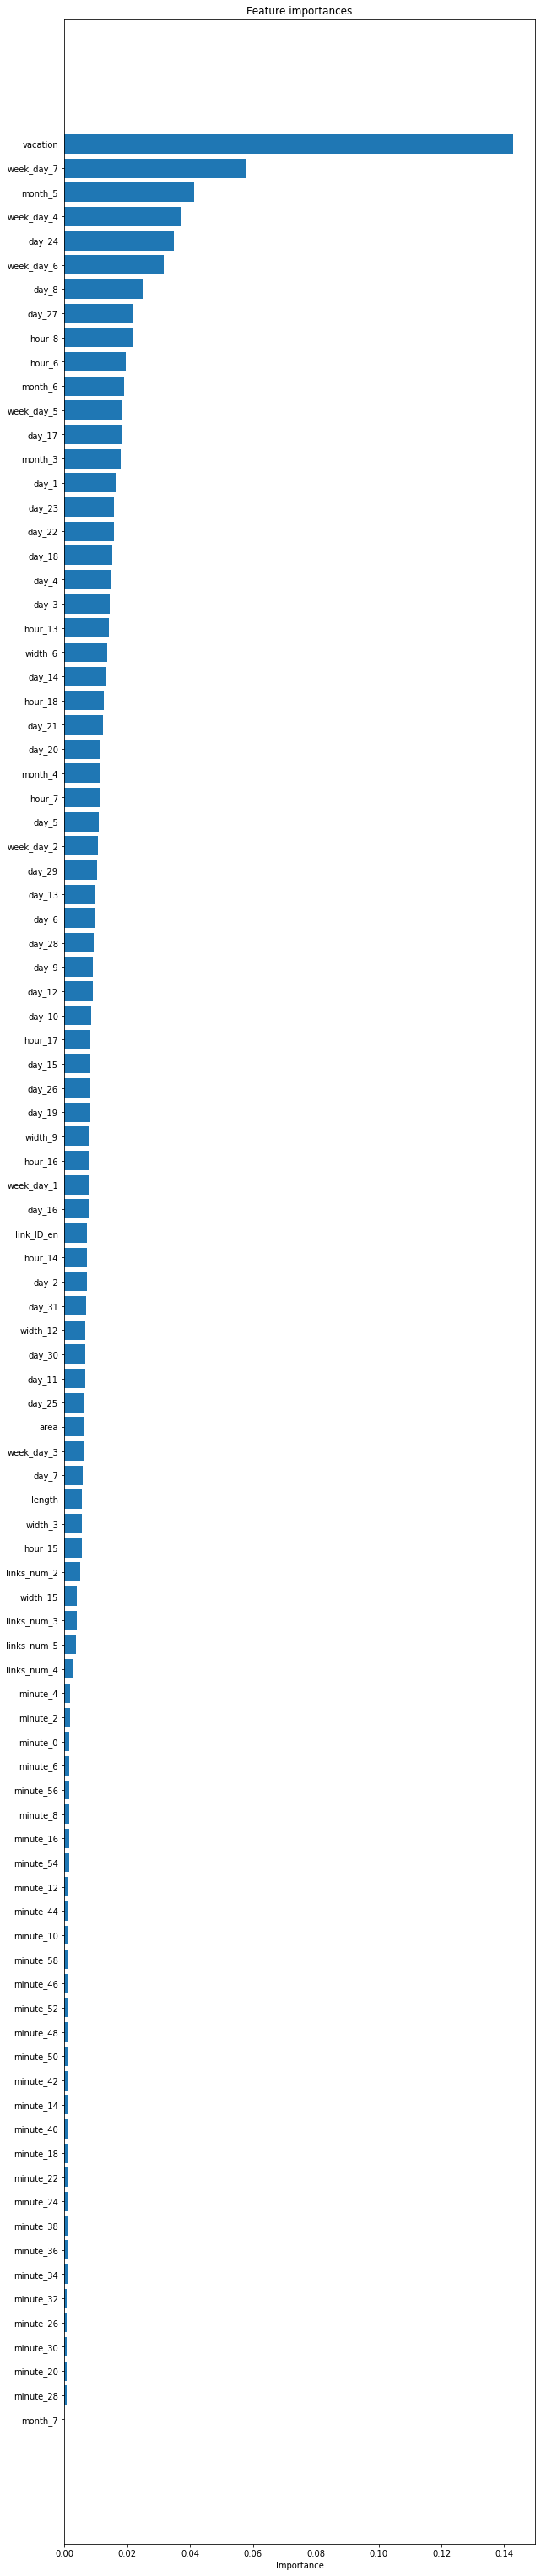

In [87]:
importance_plt(train_feature, regressor.feature_importances_)

最重要的是vacation，是否是假期对结果的影响非常重要

还原预测结果

In [88]:
df['imputation1'] = df['travel_time'].isnull()
df['travel_time'] = df['travel_time'].fillna(value=df['prediction'])
df['travel_time'] = (df['travel_time']
                     * np.array(df['travel_time_std'])
                    + np.array(df['minute_trend'])
                    + np.array(df['date_trend']))

In [89]:
df.head()

,link_ID,time_interval_begin,date,travel_time,travel_time2,date_trend,minute_trend,length,area,vacation,...,day_31,month_3,month_4,month_5,month_6,month_7,prediction_x,prediction_y,imputationl,prediction
0,3377906280028510514,2017-03-01 06:00:00,2017-03-01,1.659311,NaN,1.960745,-0.252121,48,144,0.0,...,0,1,0,0,0,0,-0.220903,-0.220903,True,-0.220903
1,3377906280028510514,2017-03-01 06:02:00,2017-03-01,1.664941,NaN,1.960745,-0.246743,48,144,0.0,...,0,1,0,0,0,0,-0.219772,-0.219772,True,-0.219772
2,3377906280028510514,2017-03-01 06:04:00,2017-03-01,1.671675,NaN,1.960745,-0.241428,48,144,0.0,...,0,1,0,0,0,0,-0.213418,-0.213418,True,-0.213418
3,3377906280028510514,2017-03-01 06:06:00,2017-03-01,1.676886,NaN,1.960745,-0.236176,48,144,0.0,...,0,1,0,0,0,0,-0.213602,-0.213602,True,-0.213602
4,3377906280028510514,2017-03-01 06:08:00,2017-03-01,1.682314,NaN,1.960745,-0.230986,48,144,0.0,...,0,1,0,0,0,0,-0.212535,-0.212535,True,-0.212535


In [90]:
print(df[['travel_time','prediction', 'travel_time2']].describe())
df[['link_ID','date','time_interval_begin','travel_time','imputation1']].to_csv('com_trainning.txt',
                                                                               header=True,
                                                                               index=None,
                                                                               sep=';',mode='w')

        travel_time    prediction  travel_time2
count  5.049000e+06  1.883574e+06  3.165426e+06
mean   2.395459e+00  7.011203e-02  2.416565e+00
std    9.192798e-01  1.871515e-01  9.521757e-01
min    3.364722e-01 -1.735234e+00  3.364722e-01
25%    1.673816e+00 -3.902411e-02  1.648659e+00
50%    2.379546e+00  7.028064e-02  2.388763e+00
75%    3.068053e+00  1.804217e-01  3.113515e+00
max    5.913699e+00  3.253515e+00  5.913699e+00


### 构建特征

In [2]:
df = pd.read_csv('com_trainning.txt',
                 delimiter=';',
                 parse_dates=['time_interval_begin'],
                dtype={'link_ID':object})

In [3]:
df1 = df.copy()
df1.head()  # imputation1如果是False表示真实值，True则是预测

,link_ID,date,time_interval_begin,travel_time,imputationl
0,3377906280028510514,2017-03-01,2017-03-01 06:00:00,1.659311,True
1,3377906280028510514,2017-03-01,2017-03-01 06:02:00,1.664941,True
2,3377906280028510514,2017-03-01,2017-03-01 06:04:00,1.671675,True
3,3377906280028510514,2017-03-01,2017-03-01 06:06:00,1.676886,True
4,3377906280028510514,2017-03-01,2017-03-01 06:08:00,1.682314,True


In [4]:
#平移5格
df1['time_interval_begin'] = df1['time_interval_begin'] + pd.DateOffset(minutes=5*2)
df1.head()

,link_ID,date,time_interval_begin,travel_time,imputationl
0,3377906280028510514,2017-03-01,2017-03-01 06:10:00,1.659311,True
1,3377906280028510514,2017-03-01,2017-03-01 06:12:00,1.664941,True
2,3377906280028510514,2017-03-01,2017-03-01 06:14:00,1.671675,True
3,3377906280028510514,2017-03-01,2017-03-01 06:16:00,1.676886,True
4,3377906280028510514,2017-03-01,2017-03-01 06:18:00,1.682314,True


In [5]:
df1 = df1.rename(columns={'travel_time':'lagging'+str(5)})
df1.head()

,link_ID,date,time_interval_begin,lagging5,imputationl
0,3377906280028510514,2017-03-01,2017-03-01 06:10:00,1.659311,True
1,3377906280028510514,2017-03-01,2017-03-01 06:12:00,1.664941,True
2,3377906280028510514,2017-03-01,2017-03-01 06:14:00,1.671675,True
3,3377906280028510514,2017-03-01,2017-03-01 06:16:00,1.676886,True
4,3377906280028510514,2017-03-01,2017-03-01 06:18:00,1.682314,True


In [6]:
df2 = pd.merge(df,df1[['link_ID','time_interval_begin','lagging'+str(5)]],
              on=['link_ID','time_interval_begin'],how='left')
df2.head(8)

,link_ID,date,time_interval_begin,travel_time,imputationl,lagging5
0,3377906280028510514,2017-03-01,2017-03-01 06:00:00,1.659311,True,NaN
1,3377906280028510514,2017-03-01,2017-03-01 06:02:00,1.664941,True,NaN
2,3377906280028510514,2017-03-01,2017-03-01 06:04:00,1.671675,True,NaN
3,3377906280028510514,2017-03-01,2017-03-01 06:06:00,1.676886,True,NaN
4,3377906280028510514,2017-03-01,2017-03-01 06:08:00,1.682314,True,NaN
5,3377906280028510514,2017-03-01,2017-03-01 06:10:00,1.629241,False,1.659311
6,3377906280028510514,2017-03-01,2017-03-01 06:12:00,1.629241,False,1.664941
7,3377906280028510514,2017-03-01,2017-03-01 06:14:00,1.629241,False,1.671675


第5行是第0行（前10分钟）的值是一样的，只是往后移动

In [7]:
def create_lagging(df, df_original, i):
    df1 = df_original.copy()
    df1['time_interval_begin'] = df1['time_interval_begin']+pd.DateOffset(minutes=i*2)
    df1 = df1.rename(columns={'travel_time':'lagging'+str(i)})
    df2 = pd.merge(df,df1[['link_ID','time_interval_begin','lagging'+str(i)]],
              on=['link_ID','time_interval_begin'],how='left')
    return df2

In [8]:
df1 = create_lagging(df, df, 1)

构建时间序列特征

In [9]:
lagging = 5
for i in range(2,lagging+1):
    df1 = create_lagging(df1,df,i)

In [10]:
df1.head(8)

,link_ID,date,time_interval_begin,travel_time,imputationl,lagging1,lagging2,lagging3,lagging4,lagging5
0,3377906280028510514,2017-03-01,2017-03-01 06:00:00,1.659311,True,NaN,NaN,NaN,NaN,NaN
1,3377906280028510514,2017-03-01,2017-03-01 06:02:00,1.664941,True,1.659311,NaN,NaN,NaN,NaN
2,3377906280028510514,2017-03-01,2017-03-01 06:04:00,1.671675,True,1.664941,1.659311,NaN,NaN,NaN
3,3377906280028510514,2017-03-01,2017-03-01 06:06:00,1.676886,True,1.671675,1.664941,1.659311,NaN,NaN
4,3377906280028510514,2017-03-01,2017-03-01 06:08:00,1.682314,True,1.676886,1.671675,1.664941,1.659311,NaN
5,3377906280028510514,2017-03-01,2017-03-01 06:10:00,1.629241,False,1.682314,1.676886,1.671675,1.664941,1.659311
6,3377906280028510514,2017-03-01,2017-03-01 06:12:00,1.629241,False,1.629241,1.682314,1.676886,1.671675,1.664941
7,3377906280028510514,2017-03-01,2017-03-01 06:14:00,1.629241,False,1.629241,1.629241,1.682314,1.676886,1.671675


In [11]:
link_infos = pd.read_csv('gy_contest_link_info.txt',delimiter=';',dtype={'link_ID':object})
link_tops = pd.read_csv('gy_contest_link_top_update.txt',delimiter=',',dtype={'link_ID':object})

In [12]:
link_tops = link_tops.fillna(0)
link_infos = pd.merge(link_infos,link_tops,on=['link_ID'],how='left')
link_infos['links_num'] = link_infos['in_links']+link_infos['out_links']

In [13]:
link_infos['area'] = link_infos['length'] * link_infos['width']
df2 = pd.merge(df1,link_infos[['link_ID','length','width',
                               'links_num','area']],on=['link_ID'],how='left')

In [14]:
df2.head()

,link_ID,date,time_interval_begin,travel_time,imputationl,lagging1,lagging2,lagging3,lagging4,lagging5,length,width,links_num,area
0,3377906280028510514,2017-03-01,2017-03-01 06:00:00,1.659311,True,NaN,NaN,NaN,NaN,NaN,48,3,2,144
1,3377906280028510514,2017-03-01,2017-03-01 06:02:00,1.664941,True,1.659311,NaN,NaN,NaN,NaN,48,3,2,144
2,3377906280028510514,2017-03-01,2017-03-01 06:04:00,1.671675,True,1.664941,1.659311,NaN,NaN,NaN,48,3,2,144
3,3377906280028510514,2017-03-01,2017-03-01 06:06:00,1.676886,True,1.671675,1.664941,1.659311,NaN,NaN,48,3,2,144
4,3377906280028510514,2017-03-01,2017-03-01 06:08:00,1.682314,True,1.676886,1.671675,1.664941,1.659311,NaN,48,3,2,144


In [15]:
# 假期特征
df2.loc[df2['date'].isin(['2017-04-02','2017-04-03','2017-04-04','2017-04-29','2017-04-30',
                       '2017-05-01','2017-05-28','2017-05-29','2017-05-30']),'vacation']=1

df2.loc[~df2['date'].isin(['2017-04-02','2017-04-03','2017-04-04','2017-04-29','2017-04-30',
                       '2017-05-01','2017-05-28','2017-05-29','2017-05-30']),'vacation']=0

In [16]:
df2.head()

,link_ID,date,time_interval_begin,travel_time,imputationl,lagging1,lagging2,lagging3,lagging4,lagging5,length,width,links_num,area,vacation
0,3377906280028510514,2017-03-01,2017-03-01 06:00:00,1.659311,True,NaN,NaN,NaN,NaN,NaN,48,3,2,144,0.0
1,3377906280028510514,2017-03-01,2017-03-01 06:02:00,1.664941,True,1.659311,NaN,NaN,NaN,NaN,48,3,2,144,0.0
2,3377906280028510514,2017-03-01,2017-03-01 06:04:00,1.671675,True,1.664941,1.659311,NaN,NaN,NaN,48,3,2,144,0.0
3,3377906280028510514,2017-03-01,2017-03-01 06:06:00,1.676886,True,1.671675,1.664941,1.659311,NaN,NaN,48,3,2,144,0.0
4,3377906280028510514,2017-03-01,2017-03-01 06:08:00,1.682314,True,1.676886,1.671675,1.664941,1.659311,NaN,48,3,2,144,0.0


In [17]:
#起始分钟特征
df2.loc[df2['time_interval_begin'].dt.hour.isin([6,7,8]),'minute_series']=\
             df2['time_interval_begin'].dt.minute+(df2['time_interval_begin'].dt.hour-6)*60

df2.loc[df2['time_interval_begin'].dt.hour.isin([13,14,15]),'minute_series']=\
             df2['time_interval_begin'].dt.minute+(df2['time_interval_begin'].dt.hour-13)*60

df2.loc[df2['time_interval_begin'].dt.hour.isin([16,17,18]),'minute_series']=\
             df2['time_interval_begin'].dt.minute+(df2['time_interval_begin'].dt.hour-16)*60

In [18]:
df2.head()

,link_ID,date,time_interval_begin,travel_time,imputationl,lagging1,lagging2,lagging3,lagging4,lagging5,length,width,links_num,area,vacation,minute_series
0,3377906280028510514,2017-03-01,2017-03-01 06:00:00,1.659311,True,NaN,NaN,NaN,NaN,NaN,48,3,2,144,0.0,0.0
1,3377906280028510514,2017-03-01,2017-03-01 06:02:00,1.664941,True,1.659311,NaN,NaN,NaN,NaN,48,3,2,144,0.0,2.0
2,3377906280028510514,2017-03-01,2017-03-01 06:04:00,1.671675,True,1.664941,1.659311,NaN,NaN,NaN,48,3,2,144,0.0,4.0
3,3377906280028510514,2017-03-01,2017-03-01 06:06:00,1.676886,True,1.671675,1.664941,1.659311,NaN,NaN,48,3,2,144,0.0,6.0
4,3377906280028510514,2017-03-01,2017-03-01 06:08:00,1.682314,True,1.676886,1.671675,1.664941,1.659311,NaN,48,3,2,144,0.0,8.0


In [19]:
# 星期特征
df2['day_of_week'] = df2['time_interval_begin'].map(lambda x: x.weekday()+1)
df2.loc[df2['day_of_week'].isin([1,2,3]),'day_of_week_en'] = 1
df2.loc[df2['day_of_week'].isin([4,5]),'day_of_week_en'] = 2
df2.loc[df2['day_of_week'].isin([6,7]),'day_of_week_en'] = 3

In [20]:
# 时间段特征
df2.loc[df['time_interval_begin'].dt.hour.isin([6,7,8]), 'hour_en']=1
df2.loc[df['time_interval_begin'].dt.hour.isin([13,14,15]), 'hour_en']=2
df2.loc[df['time_interval_begin'].dt.hour.isin([16,17,18]), 'hour_en']=3

In [21]:
# 星期，时间段合并特征
df2['week_hour'] = df2['day_of_week_en'].astype('str') + ','+df2['hour_en'].astype('str')

In [22]:
df2.head()

,link_ID,date,time_interval_begin,travel_time,imputationl,lagging1,lagging2,lagging3,lagging4,lagging5,length,width,links_num,area,vacation,minute_series,day_of_week,day_of_week_en,hour_en,week_hour
0,3377906280028510514,2017-03-01,2017-03-01 06:00:00,1.659311,True,NaN,NaN,NaN,NaN,NaN,48,3,2,144,0.0,0.0,3,1.0,1.0,"1.0,1.0"
1,3377906280028510514,2017-03-01,2017-03-01 06:02:00,1.664941,True,1.659311,NaN,NaN,NaN,NaN,48,3,2,144,0.0,2.0,3,1.0,1.0,"1.0,1.0"
2,3377906280028510514,2017-03-01,2017-03-01 06:04:00,1.671675,True,1.664941,1.659311,NaN,NaN,NaN,48,3,2,144,0.0,4.0,3,1.0,1.0,"1.0,1.0"
3,3377906280028510514,2017-03-01,2017-03-01 06:06:00,1.676886,True,1.671675,1.664941,1.659311,NaN,NaN,48,3,2,144,0.0,6.0,3,1.0,1.0,"1.0,1.0"
4,3377906280028510514,2017-03-01,2017-03-01 06:08:00,1.682314,True,1.676886,1.671675,1.664941,1.659311,NaN,48,3,2,144,0.0,8.0,3,1.0,1.0,"1.0,1.0"


In [23]:
df2 = pd.get_dummies(df2,columns=['week_hour','links_num','width'])

In [24]:
def mean_time(group):
    group['link_ID_en'] = group['travel_time'].mean()
    return group

In [25]:
df2 = df2.groupby('link_ID').apply(mean_time)

In [26]:
sorted_link = np.sort(df2['link_ID_en'].unique())
df2['link_ID_en'] = df2['link_ID_en'].map(lambda x: np.argmin(x >= sorted_link))

In [27]:
df2.head()

,link_ID,date,time_interval_begin,travel_time,imputationl,lagging1,lagging2,lagging3,lagging4,lagging5,...,links_num_2,links_num_3,links_num_4,links_num_5,width_3,width_6,width_9,width_12,width_15,link_ID_en
0,3377906280028510514,2017-03-01,2017-03-01 06:00:00,1.659311,True,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,1,0,0,0,0,47
1,3377906280028510514,2017-03-01,2017-03-01 06:02:00,1.664941,True,1.659311,NaN,NaN,NaN,NaN,...,1,0,0,0,1,0,0,0,0,47
2,3377906280028510514,2017-03-01,2017-03-01 06:04:00,1.671675,True,1.664941,1.659311,NaN,NaN,NaN,...,1,0,0,0,1,0,0,0,0,47
3,3377906280028510514,2017-03-01,2017-03-01 06:06:00,1.676886,True,1.671675,1.664941,1.659311,NaN,NaN,...,1,0,0,0,1,0,0,0,0,47
4,3377906280028510514,2017-03-01,2017-03-01 06:08:00,1.682314,True,1.676886,1.671675,1.664941,1.659311,NaN,...,1,0,0,0,1,0,0,0,0,47


In [32]:
df2.to_csv('trainning.txt',header=True,index=None,sep=';',mode='w')